# XDMoD Python API Raw Data Example
University at Buffalo — Center for Computational Research

## Introduction
The `xdmod` Python module provides API access to the data in XDMoD. This notebook shows an example of how to use the `get_raw_data()` method to obtain and process individual records. In this example, you will obtain job performance data, which is contained in the `SUPREMM` realm in XDMoD, and use the data to train a machine learning model.

## Import the XDMoD Data Warehouse module

In [1]:
from xdmod.datawarehouse import DataWarehouse

## Configure IPython notebook formatting of plots and tables

In [1]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]

def display_df_md_table(df):
    return display(Markdown(df.replace('\n', '<br/>', regex=True).to_markdown()))

## Initialize the data warehouse
To access the data in XDMoD, you first need to construct a `DataWarehouse` object and provide the URL of the XDMoD instance as well as an API token or equivalent authentication information. In this prototype, the API token is set to `None`, which causes the Python code to pull the authentication data from shell environment variables.

In [1]:
dw = DataWarehouse(xdmod_host='https://xdmod-dev.ccr.xdmod.org:9001', api_token=None)

## Get the raw data

The `get_raw_data()` function returns a Pandas DataFrame containing individual records. You must specify a duration and a realm. You can specify specific fields to return. You can also specify a collection of filters.

In [1]:
with dw:
    supremmjobs = dw.get_raw_data(
        duration=('2021-05-01', '2021-05-02'),
        realm='SUPREMM',
        # omit the fields parameter to get all data fields
        fields=(
            'CPU User',
            'Nodes',
            'Wall Time',
            'Wait Time',
            'Requested Wall Time',
            'Total memory used',
            'Mount point "home" data written',
            'Mount point "scratch" data written',
        ),
        # omit the filters parameter to apply no filters
        filters = {
            'Resource': [
                'STAMPEDE2 TACC',
                'Bridges 2 RM',
            ],
        },
    )

## Inspect the data

In [1]:
print(type(supremmjobs))

<class 'pandas.core.frame.DataFrame'>


In [1]:
display(supremmjobs)

,Nodes,Requested Wall Time,Wait Time,Wall Time,CPU User,"Mount point ""home"" data written","Mount point ""scratch"" data written",Total memory used
0,1,18000,2223,61,45.33680231265288,NaN,NaN,NaN
1,1,3600,5602,1543,99.36066240441603,NaN,NaN,57124648082.28572
2,1,21600,107620,5976,5.880114964292324,NaN,NaN,168170816756.3046
3,2,86400,62768,29837,98.36955300852983,NaN,NaN,409481210204.9054
4,1,3600,5282,1906,98.67883597883598,NaN,NaN,118448399591.22581
...,...,...,...,...,...,...,...,...
34663,1,21600,279846,5904,5.888494319804227,NaN,NaN,263141275141.27835
34664,4,660,15,15,1.6348917522553061,395.28992589908404,0,149108855
34665,1,21600,279665,6098,5.9966003503148,NaN,NaN,122776391659.7228
34666,1,21600,279846,5917,5.9687171009043904,NaN,NaN,263236402842.91272


## Prepare data for training

Looking at the summary table, there are some records that have `NaN` values. This is not unusal and is typically because the data were not collected (insufficient data points, errors in the data collection, etc.).

To prepare for training, filter out the jobs that have no filesystem data:

In [1]:
supremmjobs = supremmjobs[supremmjobs['Mount point "scratch" data written'].notna()]

Set the data type of the columns to 64-bit floating-point:

In [1]:
import numpy as np
supremmjobs = supremmjobs.astype(np.float64)

Use [scikit-learn](https://scikit-learn.org/) to split the jobs into a training set and test set:

In [1]:
from sklearn.model_selection import train_test_split
X = supremmjobs[[
    'Nodes',
    'Wall Time',
    'Wait Time',
    'Requested Wall Time',
    'Total memory used',
    'Mount point "home" data written',
    'Mount point "scratch" data written',
]]
y = supremmjobs['CPU User']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
display(Markdown("Size of the test subset is **" + str(len(X_test)) + "**."))
display(Markdown("Size of the training subset is **" + str(len(X_train)) + "**."))

Size of the test subset is **997**.

Size of the training subset is **8966**.

## Generate a Random Forest Regression model

Using the tools from `scikit-learn`, build a Random Forest Regression model.

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

RandomForestRegModel = RandomForestRegressor()
RandomForestRegModel.fit(X_train, y_train)

RandomForestRegressor()

## Compute feature importances

In [1]:
import numpy as np
importances = RandomForestRegModel.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in RandomForestRegModel.estimators_],
    axis=0,
)
indices = np.argsort(importances)[::-1]
# Calculate feature importances
importances = RandomForestRegModel.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]
md = "|Feature Name | Importance |\n|-------|:----|\n"
for i in indices:
    md += "|{}|{:1.4}|\n".format(names[i], importances[i])
display(Markdown(md))

|Feature Name | Importance |
|-------|:----|
|Mount point "home" data written|0.3771|
|Requested Wall Time|0.2363|
|Wall Time|0.1012|
|Mount point "scratch" data written|0.09661|
|Wait Time|0.07337|
|Total memory used|0.0603|
|Nodes|0.05506|


Training data r_squared: 0.9888
Test data r_squared: 0.8937


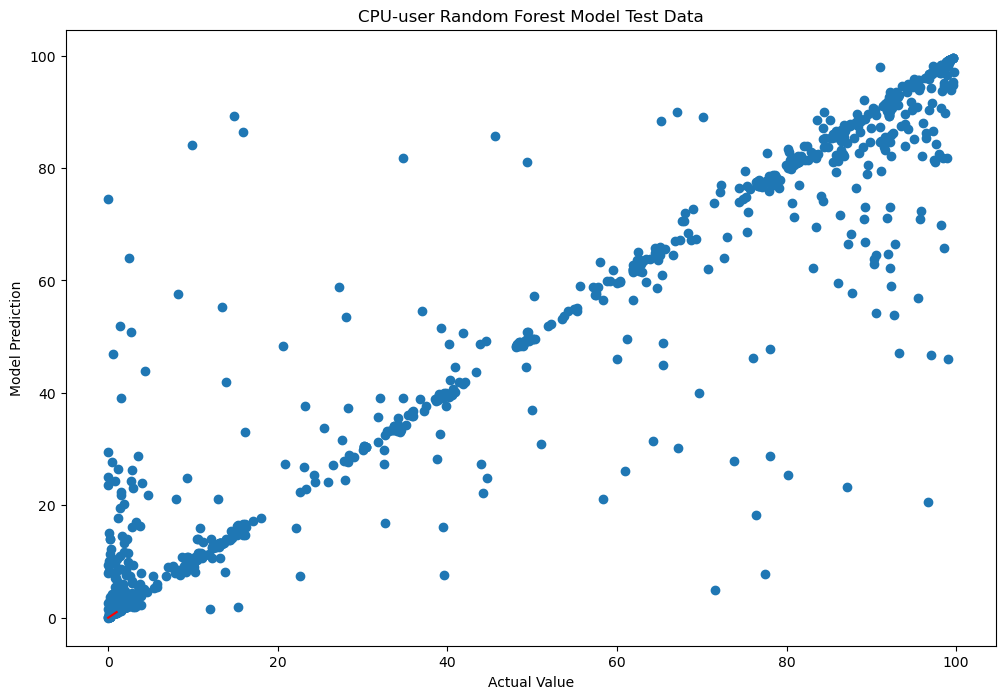

In [1]:
X_train_predict = RandomForestRegModel.predict(X_train)
print("Training data r_squared:", round(r2_score(X_train_predict, y_train), 4))
X_test_predict = RandomForestRegModel.predict(X_test)
print("Test data r_squared:", round(r2_score(X_test_predict, y_test), 4))
# Make scatter plot of CPU-user: model vs. actual
import matplotlib.pyplot as plt
plt.scatter(y_test, X_test_predict)
plt.ylabel('Model Prediction')
plt.xlabel('Actual Value')
plt.title('CPU-user Random Forest Model Test Data')
point1 = [0, 0]
point2 = [1, 1]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'r')
plt.show()

## Details of the `get_raw_data()` method
Now that you have seen an example of using the `get_raw_data()` method, read below for more details on how it works.

### Wrap data warehouse calls in a runtime context
XDMoD data is accessed over a network connection, which involves establishing connections and creating temporary resources. To ensure these connections and resources are cleaned up properly in spite of any runtime errors, you should call data warehouse methods within a **runtime context** by using Python's `with` statement to wrap the execution of XDMoD queries, store the result, and execute any long running calculations outside of the runtime context:

In [1]:
with dw:
    # XDMoD queries would go here
    pass
# Data processing would go here
pass

### Parameters
The `get_raw_data()` method has a number of parameters explained in detail below.

### Duration
The **duration** provides the time constraints of the data to be fetched from the XDMoD data warehouse. You can get a list of valid durations by calling the `get_durations()` method.

In [1]:
with dw:
    print(dw.get_durations())

('Yesterday', '7 day', '30 day', '90 day', 'Month to date', 'Previous month', 'Quarter to date', 'Previous quarter', 'Year to date', 'Previous year', '1 year', '2 year', '3 year', '5 year', '10 year', '2023', '2022', '2021', '2020', '2019', '2018', '2017')


The duration can instead be specified as start and end times:

In [1]:
with dw:
    data = dw.get_raw_data(
        duration=('2022-01-01', '2022-01-01'),
        realm='SUPREMM'
    )

### Realm
A **realm** is a category of data in the XDMoD data warehouse. You can use the `get_raw_realms()` method to get a DataFrame containing the set of realms for which raw data is available.

In [1]:
with dw:
    display_df_md_table(dw.get_raw_realms())

| id                  | label                |
|:--------------------|:---------------------|
| Jobs                | Jobs                 |
| Cloud               | Cloud                |
| Accounts            | Accounts             |
| ResourceAllocations | Resource Allocations |
| Allocations         | Allocations          |
| SUPREMM             | SUPREMM              |

### Fields
A **field** is a measurement for which raw data exists in a given realm. You can use the `get_raw_fields(realm)` method to get a DataFrame containing the set of valid fields in the given realm. The realm must be passed in as a string.

In [1]:
with dw:
    display_df_md_table(dw.get_raw_fields('SUPREMM'))

| id                               | label                                            | description                                                                                                                                                                                      |
|:---------------------------------|:-------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| local_job_id                     | Local Job Id                                     | The unique identifier assigned to the job by the job scheduler.                                                                                                                                  |
| username                         | System Username (Deidentified)                   | The username on the resource of the user that ran the job. May be a UID or string username depending on the resource.                                                                            |
| shared                           | Shared                                           | Whether the job ran on a node that ran at least one other job.                                                                                                                                   |
| cores                            | Cores                                            | The total number of cores assigned to the job.                                                                                                                                                   |
| gpu_count                        | Gpu Count                                        | The total number of GPUs assigned to the job.                                                                                                                                                    |
| nodes                            | Nodes                                            | The number of nodes that were assigned to the job.                                                                                                                                               |
| cores_avail                      | Total Cores Available                            | Total number of cores present on the nodes on which the job ran.                                                                                                                                 |
| cpu_time                         | Cpu Time                                         | The total CPU core time. This value is calculated as number of assigned cores multiplied by duration if not provided by the scheduler.                                                           |
| gpu_time                         | Gpu Time                                         | The total GPU time. This value is calculated as number of assigned GPUs multiplied by duration.                                                                                                  |
| node_time                        | Node Time                                        | Total node time. This value is calculated as number of assigned nodes multiplied by duration if not provided by the scheduler.                                                                   |
| requested_nodes                  | Requested Nodes                                  | The number of nodes requested at job submission time. This value will be zero if the user did not specify the number of required nodes or if this information is not provided for the resource.  |
| requested_wall_time              | Requested Wall Time                              | The requested job duration.                                                                                                                                                                      |
| queue_id                         | Queue                                            | The name of the queue to which the job was submitted.                                                                                                                                            |
| wait_time                        | Wait Time                                        | The amount of time between job submit and job start.                                                                                                                                             |
| wall_time                        | Wall Time                                        | The wall-clock duration of the job.                                                                                                                                                              |
| eligible_time_ts                 | Eligible Time (Timestamp)                        | The time that the job was ready to be run by the scheduler.                                                                                                                                      |
| end_time_ts                      | End Time (Timestamp)                             | The time that the job ended.                                                                                                                                                                     |
| start_time_ts                    | Start Time (Timestamp)                           | The time that the job started running.                                                                                                                                                           |
| submit_time_ts                   | Submit Time (Timestamp)                          | The time that the job was submitted to the job scheduler.                                                                                                                                        |
| Organization                     | Organization                                     | The organization that owns the resource on which the job ran.                                                                                                                                    |
| Resource                         | Resource                                         | The resource that ran the job.                                                                                                                                                                   |
| Field of Science                 | Field of Science                                 | The field of science indicated on the allocation request pertaining to the running jobs.                                                                                                         |
| PI                               | PI                                               | The PI of the job owner.                                                                                                                                                                         |
| Timezone                         | Timezone                                         | The timezone of the resource.                                                                                                                                                                    |
| User                             | User                                             | The name of the job owner.                                                                                                                                                                       |
| User Institution                 | User Institution                                 | The name of the organization of the job owner.                                                                                                                                                   |
| gpu_usage                        | GPU usage                                        | Average % utilization of the GPUs. The average is calculated as the mean value of the utilization reported by the GPU driver during the job.                                                     |
| gpu0_nv_mem_used                 | GPU average memory usage                         | Average memory used by the GPUs. The average is calculated as the mean value of all measurements for all GPUs while the job was running. The memory usage value is obtained from the GPU driver. |
| cpu_idle                         | CPU Idle                                         | The ratio of idle cpu time to total cpu time for the cores that the job was assigned.                                                                                                            |
| cpu_system                       | CPU System                                       | The ratio of system cpu time to total cpu time for the cores that the job was assigned.                                                                                                          |
| cpu_user                         | CPU User                                         | The ratio of user cpu time to total cpu time for the cores that the job was assigned.                                                                                                            |
| flops                            | FLOPS                                            | The total number of floating point operations on average per core                                                                                                                                |
| cpiref                           | CPI (ref)                                        | The number of cpu clock ticks per instruction on average per core.                                                                                                                               |
| cpiref_cov                       | CPI (ref) cov                                    | Coefficient of variation of the average CPI for each core                                                                                                                                        |
| cpldref                          | CPLD (ref)                                       | The ratio of clock ticks to L1D cache load on average per core. The CPLD is calculated using the reference processor clock.                                                                      |
| cpldref_cov                      | CPLD (ref) cov                                   | Coefficient of variation of the average CPLD for each core                                                                                                                                       |
| cpu_user_cv                      | CPU User cov                                     | Coefficient of variation for the CPU user for all cores that were assigned to the job.                                                                                                           |
| flops_cov                        | FLOPS cov                                        | Coefficient of variation of the average FLOPS for each core                                                                                                                                      |
| block_sda_rd_bytes               | Block device "sda" data read                     | The average amount of data read per node from block device sda.                                                                                                                                  |
| block_sda_wr_bytes               | Block device "sda" data written                  | The average number of bytes written per node to block device sda.                                                                                                                                |
| netdir_home_read                 | Mount point "home" data read                     | Average number of bytes per node read from filesystem device home                                                                                                                                |
| netdir_home_write                | Mount point "home" data written                  | The average number of bytes written per node to mount point home.                                                                                                                                |
| netdir_scratch_read              | Mount point "scratch" data read                  | Average number of bytes per node read from filesystem device scratch                                                                                                                             |
| netdir_scratch_write             | Mount point "scratch" data written               | The average number of bytes written per node to mount point scratch.                                                                                                                             |
| netdir_work_read                 | Mount point "work" data read                     | Average number of bytes per node read from filesystem device work                                                                                                                                |
| netdir_work_write                | Mount point "work" data written                  | The average number of bytes written per node to mount point work.                                                                                                                                |
| block_sda_rd_ios                 | Block device "sda" read operations               | The average number of read operations per node for block device sda.                                                                                                                             |
| block_sda_wr_ios                 | Block device "sda" write operations              | The average number of write operations per node for block device sda.                                                                                                                            |
| block_sda_rd_bytes_cov           | Block device "sda" data read cov                 | Coefficient of variation of the average data read from block device sda                                                                                                                          |
| block_sda_wr_bytes_cov           | Block device "sda" data written cov              | Coefficient of variation of the average data written to block device sda                                                                                                                         |
| netdir_home_write_cov            | Mount point "home" data written cov              | Coefficient of variation of the average bytes written to the home filesystem                                                                                                                     |
| netdir_scratch_write_cov         | Mount point "scratch" data written cov           | Coefficient of variation of the average bytes written to the scratch filesystem                                                                                                                  |
| netdir_work_write_cov            | Mount point "work" data written cov              | Coefficient of variation of the average bytes written to the work filesystem                                                                                                                     |
| mem_transferred                  | Memory Transferred                               | total data transferred over the memory bus                                                                                                                                                       |
| mem_used_including_os_caches     | Total memory used                                | Total memory used by the OS including the page and buffer caches. This is the sum of all the memory used on all of the nodes.                                                                    |
| mem_transferred_cov              | Memory Transferred cov                           | Coefficient of variation of the average memory transferred for each socket                                                                                                                       |
| memory_used_cov                  | Memory Used Cov                                  | Coefficient of variation of the average memory used                                                                                                                                              |
| max_memory                       | Peak Memory Usage Ratio                          | Maximum ratio of memory used to total memory available for the compute node with the highest peak memory usage                                                                                   |
| mem_used_including_os_caches_cov | Total memory used cov                            | Coefficient of variation of the average memory in use by the OS                                                                                                                                  |
| ib_rx_bytes                      | Ib Rx Bytes                                      | number of bytes received per node over the data interconnect                                                                                                                                     |
| net_eth0_rx                      | Net Eth0 Rx                                      | number of bytes received by network via network interface eth0 averaged across nodes                                                                                                             |
| net_eth0_tx                      | Net Eth0 Tx                                      | number of bytes transmitted by network via network interface eth0 averaged across nodes                                                                                                          |
| net_ib0_rx                       | Net Ib0 Rx                                       | number of bytes received by network via network interface ib0 averaged across nodes                                                                                                              |
| net_ib0_tx                       | Net Ib0 Tx                                       | number of bytes transmitted by network via network interface ib0 averaged across nodes                                                                                                           |
| net_mic0_rx                      | Net Mic0 Rx                                      | number of bytes received by network via network interface mic0 averaged across nodes                                                                                                             |
| net_mic0_tx                      | Net Mic0 Tx                                      | number of bytes transmitted by network via network interface mic0 averaged across nodes                                                                                                          |
| net_mic1_rx                      | Net Mic1 Rx                                      | number of bytes received by network via network interface mic1 averaged across nodes                                                                                                             |
| net_mic1_tx                      | Net Mic1 Tx                                      | number of bytes transmitted by network via network interface mic1 averaged across nodes                                                                                                          |
| netdrv_lustre_rx                 | Parallel filesystem lustre bytes received        | total number of bytes received per node from the lustre filesystem.                                                                                                                              |
| netdrv_lustre_tx                 | Parallel filesystem lustre bytes transmitted     | number of bytes transmitted by network drive lustre averaged across nodes.                                                                                                                       |
| netdrv_lustre_rx_msgs            | Parallel filesystem lustre messages received     | number of messages received by network drive lustre averaged across nodes.                                                                                                                       |
| netdrv_lustre_tx_msgs            | Parallel filesystem lustre messages transmitted  | number of messages transmitted by network drive lustre averaged across nodes.                                                                                                                    |
| net_eth0_rx_packets              | Net Eth0 Rx Packets                              | number of packets received by network via network interface eth0 averaged across nodes                                                                                                           |
| net_eth0_tx_packets              | Net Eth0 Tx Packets                              | number of packets transmitted by network via network interface eth0 averaged across nodes                                                                                                        |
| net_ib0_rx_packets               | Net Ib0 Rx Packets                               | number of packets received by network via network interface ib0 averaged across nodes                                                                                                            |
| net_ib0_tx_packets               | Net Ib0 Tx Packets                               | number of packets transmitted by network via network interface ib0 averaged across nodes                                                                                                         |
| net_mic0_rx_packets              | Net Mic0 Rx Packets                              | number of packets received by network via network interface mic0 averaged across nodes                                                                                                           |
| net_mic0_tx_packets              | Net Mic0 Tx Packets                              | number of packets transmitted by network via network interface mic0 averaged across nodes                                                                                                        |
| net_mic1_rx_packets              | Net Mic1 Rx Packets                              | number of packets received by network via network interface mic1 averaged across nodes                                                                                                           |
| net_mic1_tx_packets              | Net Mic1 Tx Packets                              | number of packets transmitted by network via network interface mic1 averaged across nodes                                                                                                        |
| net_eth0_rx_cov                  | Net Eth0 Rx Cov                                  | Coefficient of variation of the average bytes received by the network device eth0 for each node.                                                                                                 |
| net_eth0_tx_cov                  | Net Eth0 Tx Cov                                  | Coefficient of variation of the average bytes transmitted by the network device eth0 for each node.                                                                                              |
| net_ib0_rx_cov                   | Net Ib0 Rx Cov                                   | Coefficient of variation of the average bytes received by the network device ib0 for each node.                                                                                                  |
| net_ib0_tx_cov                   | Net Ib0 Tx Cov                                   | Coefficient of variation of the average bytes transmitted by the network device ib0 for each node.                                                                                               |
| netdrv_lustre_tx_cov             | Parallel filesystem lustre bytes transmitted cov | Coefficient of variation of the average bytes written to the lustre parallel filesystem for each node.                                                                                           |

### Filters
**Filters** allow you to include only data that have certain values for given **dimensions**, which are groupings of data. You can use the `get_dimensions(realm)` method to get a DataFrame containing the list of valid dimensions in the given realm. The realm must be passed in as a string and can be either the ID or the label of the realm.

In [1]:
with dw:
    dimensions = dw.get_dimensions('SUPREMM')
    display_df_md_table(dimensions)

| id                          | label                      | description                                                                                                                                                                                                                                                                                                     |
|:----------------------------|:---------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| none                        | None                       | Summarizes job performance data obtained via the SUPReMM project. These data are obtained from performance monitoring software running on each HPC resource. For most resources this data is generated for both ACCESS and non-ACCESS jobs. Non-ACCESS jobs can be filtered using a filter on the "Grant Type". |
| application                 | Application                | The classication of the job as common scientific application.                                                                                                                                                                                                                                                   |
| appclassmethod_id           | Application Class. Method  | The classification algorithm that was used to identify the application.                                                                                                                                                                                                                                         |
| cpi                         | CPI Value                  | The number of cpu clock ticks per instruction on average per core.                                                                                                                                                                                                                                              |
| cpucv                       | CPU User CV                | Coefficient of variation for the CPU user for all cores that were assigned to the job.                                                                                                                                                                                                                          |
| cpuuser                     | CPU User Value             | The ratio of user cpu time to total cpu time for the cores that the job was assigned.                                                                                                                                                                                                                           |
| catastrophe_bucket_id       | Catastrophe Rank           | indicator L1D cache load drop off (smaller is worse)                                                                                                                                                                                                                                                            |
| datasource                  | Datasource                 | The software used to collect the performance data.                                                                                                                                                                                                                                                              |
| exit_status                 | Exit Status                | A categorization of jobs into discrete groups based on the exit status of each job reported by the resource manager.                                                                                                                                                                                            |
| fieldofscience              | Field of Science           | The field of science indicated on the allocation request pertaining to the running jobs.                                                                                                                                                                                                                        |
| gpu_usage_bucketid          | GPU Usage Value            | Average % utilization of the GPUs. The average is calculated as the mean value of the utilization reported by the GPU driver during the job.                                                                                                                                                                    |
| grant_type                  | Grant Type                 | A categorization of the projects/allocations.                                                                                                                                                                                                                                                                   |
| granted_pe                  | Granted Processing Element | How many cores within one node.                                                                                                                                                                                                                                                                                 |
| homogeneity_bucket_id       | Homogeneity Rank           | The homogeneity is a measure of the how uniform the L1D load rate is over the lifetime of a job. Jobs with low homogeneity value (near 0) should be investigated to check if an error has caused data processing to stop prematurely.                                                                           |
| ibrxbyterate_bucket_id      | InfiniBand Receive rate    | number of bytes received per node over the data interconnect                                                                                                                                                                                                                                                    |
| jobsize                     | Job Size                   | A categorization of jobs into discrete groups based on the number of cores used by each job.                                                                                                                                                                                                                    |
| jobwalltime                 | Job Wall Time              | A categorization of jobs into discrete groups based on the total linear time each job took to execute.                                                                                                                                                                                                          |
| nsfdirectorate              | NSF Directorate            | The NSF directorate of the field of science indiciated on the allocation request pertaining to the running jobs.                                                                                                                                                                                                |
| nodecount                   | Node Count                 | A categorization of jobs into discrete groups based on node count.                                                                                                                                                                                                                                              |
| pi                          | PI                         | The principal investigator of a project.                                                                                                                                                                                                                                                                        |
| pi_institution              | PI Institution             | Organizations that have PIs with allocations.                                                                                                                                                                                                                                                                   |
| parentscience               | Parent Science             | The parent of the field of science indiciated on the allocation request pertaining to the running jobs.                                                                                                                                                                                                         |
| max_mem                     | Peak memory usage          | Maximum ratio of memory used to total memory available for the compute node with the highest peak memory usage                                                                                                                                                                                                  |
| queue                       | Queue                      | Queue pertains to the low level job queues on each resource.                                                                                                                                                                                                                                                    |
| resource                    | Resource                   | A resource is a remote computer that can run jobs.                                                                                                                                                                                                                                                              |
| provider                    | Service Provider           | A service provider is an institution that hosts resources.                                                                                                                                                                                                                                                      |
| shared                      | Share Mode                 | A categorization of jobs into discrete groups based on whether the job shared nodes.                                                                                                                                                                                                                            |
| username                    | System Username            | The specific system username of the users who ran jobs.                                                                                                                                                                                                                                                         |
| person                      | User                       | A person who is on a PIs allocation, hence able run jobs on resources.                                                                                                                                                                                                                                          |
| institution                 | User Institution           | Organizations that have users with allocations.                                                                                                                                                                                                                                                                 |
| wall_time_accuracy_bucketid | Wall Time Accuracy Value   | The wall-clock duration of the job.                                                                                                                                                                                                                                                                             |
| netdrv_lustre_rx_bucket_id  | lustre bytes received      | total number of bytes received per node from the lustre filesystem.                                                                                                                                                                                                                                             |

You can use the `get_filters(realm, dimension)` method to get a DataFrame containing the list of valid filter values for the given dimension in the given realm. The realm and dimension must be passed in as strings.

In [1]:
with dw:
    filters = dw.get_filters('SUPREMM', 'Service Provider') # 'provider' also works
    display_df_md_table(filters)

|    id | label      |
|------:|:-----------|
|  2734 | CCT-LSU    |
|   848 | PSC        |
|   856 | SDSC       |
| 14449 | StonyBrook |
|   453 | NICS       |
|   476 | TACC       |

For methods in the API that take filters as arguments, you must specify the filters as a dictionary in which the keys are dimensions (labels or IDs) and the values are string filter values (labels or IDs) or sequences of string filter values. For example, to return only data for which the field of science is materials engineering and the service provider is either PSC or SDSC:

In [1]:
with dw:
    data = dw.get_raw_data(
        duration=('2021-05-01', '2021-05-05'),
        realm='SUPREMM',
        filters={
            'Field of Science': 'Materials Engineering', # 'fieldofscience': '177' also works
            'Service Provider': ( # 'provider' also works
                'PSC', # '848' also works
                'SDSC', # '856' also works
            ),
        },
    )